In [ ]:
# 0. A Function creating new CSV files as difference between the models for each protein (20000)

# 1. A function that plots like esm the variant scores in heatmap and creat
    # Input:    Matrix rank CSV files of both models and difference matrix
    # Computes: Differences per Residue 
    # Output 3 Matrices 19xprotein length in colors 


# 2. Compute average score per residue type of all proteins


In [1]:
# --- Project Setup ---
from setup_notebook import setup_project_root
setup_project_root()

import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import requests
from matplotlib.colors import LinearSegmentedColormap
from src.project_config import get_paths

In [4]:
paths = get_paths()
esm_path = paths["esm_path"]
am_path = paths["am_path"]
difference_path = paths["difference_path"]
print(paths)

{'project_root': PosixPath('/Users/doma/Documents/Bachelor_Arbeit/Code'), 'esm_path': PosixPath('/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/ESM1b_rank_csv'), 'am_path': PosixPath('/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/AlphaMissense_rank_csv'), 'difference_path': PosixPath('/Users/doma/Documents/Bachelor_Arbeit/Code/data/processed/difference_rank_csv'), 'images_path': PosixPath('/Users/doma/Documents/Bachelor_Arbeit/Code/results/images')}


### 1. Compute Difference Matrices CSV Files for Human Proteome

In [56]:
# For every file in the esm_path folder, compute the difference with the corresponding file in am_path
# Every CSV file is a matrix and both models have exactly aligned cells

def compute_difference(esm_path, am_path, difference_path):
    esm_files = {file.replace("_LLR_rank.csv", "") for file in os.listdir(esm_path)}
    am_files = {file.replace("_rank.csv", "") for file in os.listdir(am_path)}

    count = 0
    mismatch = []

    # Find common files in both directories
    common_files = sorted(esm_files.intersection(am_files))
    print(f"Common files: {len(common_files)}")
    
    for file in tqdm(common_files, total=len(common_files)):
        esm_file = f"{file}_LLR_rank.csv"
        am_file = f"{file}_rank.csv"

        esm_df = pd.read_csv(esm_path / esm_file, index_col=0)
        am_df = pd.read_csv(am_path / am_file, index_col=0)

        # Ensure both dataframes have the same shape
        if esm_df.shape != am_df.shape:
            count += 1
            tqdm.write(f"Shape mismatch for {file} - {count} Skipping.")
            mismatch.append(file)
            continue

        # Compute the difference and round to 5 decimal places
        difference_df = (esm_df - am_df).round(5)

        # Save the difference dataframe to a new CSV file
        difference_filename = f"{file}_rank_difference.csv"
        difference_df.to_csv(difference_path / difference_filename)


    mismatch = pd.DataFrame(mismatch)
    mismatch.to_csv(difference_path / "000mismatch_files.csv", index=False, header=False)
    print("Difference computation completed for all common files.") 

In [ ]:
compute_difference(esm_path, am_path, difference_path)

### 2. Plot Heatmaps

In [6]:
# Create a heat map for the matrix in protein CSV files
def plot_heatmap(data_diff, data_am, data_esm):
    fig, axes = plt.subplots(3, 1, figsize=(len(data_diff.columns) / 5, 18), sharex=True)  # Create 3 subplots vertically



    # Plot AlphaMissense rank scores heatmap
    sns.heatmap(data_am, annot=False, cmap="RdBu_r", cbar=True, ax=axes[0], vmin=0, vmax=1,
                 cbar_kws={'shrink': 1, 'aspect': 5, 'pad': 0.01})
    axes[0].set_ylabel("Variant Residue")
    axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    

    # Plot ESM rank scores heatmap
    sns.heatmap(data_esm, annot=False, cmap="viridis", cbar=True, ax=axes[1], vmin=0, vmax=1,
                cbar_kws={'shrink': 1, 'aspect': 5, 'pad': 0.01})  # Adjust 'pad' to move cbar closer
    axes[1].set_ylabel("Variant Residue")
    axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # Plot difference heatmap with red to blue color range
    max_val_diff = max(abs(data_diff.max().max()), abs(data_diff.min().min()))
    heatmap = sns.heatmap(data_diff, annot=False, cmap="BrBG", cbar=True, ax=axes[2], vmin=-max_val_diff, vmax=max_val_diff, 
                          cbar_kws={'shrink': 1, 'aspect': 5, 'pad': 0.01}) # Adjust 'pad' to move cbar closer
    axes[2].set_ylabel("Variant Residue")
    axes[2].tick_params(axis='x', rotation=90)
    axes[2].set_xticks([i + 0.5 for i in range(len(data_diff.columns))])  # Shift ticks to the middle of the cells
    axes[2].set_xticklabels(data_diff.columns, rotation=90)

   

    # Add colorbar labels for the difference heatmap
    cbar_diff = heatmap.collections[0].colorbar
   
    cbar_diff.ax.text(1.5, 0.5, "Difference", rotation=90, va="center", ha="left", transform=cbar_diff.ax.transAxes,
                      color='black', fontsize=30, fontweight='bold')

    # Add colorbar labels for the AlphaMissense heatmap
    cbar_am = axes[0].collections[0].colorbar
    cbar_am.ax.text(1.5, 0.5, "AlphaMissense Rank", rotation=90, va="center", ha="left", transform=cbar_am.ax.transAxes,
                    color='black', fontsize=30, fontweight='bold')

    # Add colorbar labels for the ESM heatmap
    cbar_esm = axes[1].collections[0].colorbar
    cbar_esm.ax.text(1.5, 0.5, "ESM1b Rank", rotation=90, va="center", ha="left", transform=cbar_esm.ax.transAxes,
                     color='black', fontsize=30, fontweight='bold')

    plt.tight_layout()
    plt.show()

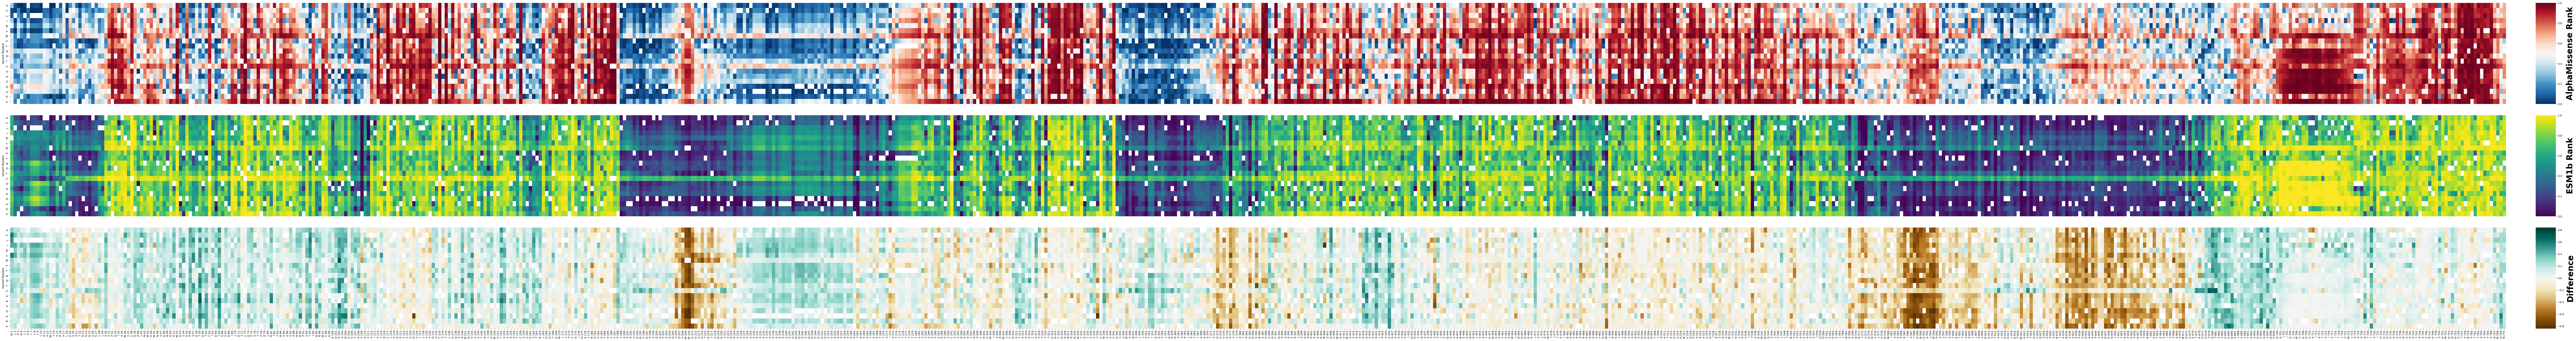

In [7]:
# Example usage
protein_id = "P05067"  
data_am = pd.read_csv(am_path / f"{protein_id}_rank.csv", index_col=0)
data_esm = pd.read_csv(esm_path / f"{protein_id}_LLR_rank.csv", index_col=0)
data_diff = pd.read_csv(difference_path / f"{protein_id}_rank_difference.csv", index_col=0)

plot_heatmap(data_diff, data_am, data_esm)


# add line plot from 5.3. visualization
# define the colors for ESm and Alphamissense in line in 5.3.
# in utils - define colors variants = for alphamissense_color = "red", esm_color = "blue"

In [ ]:
# secondary structure  - alpha, beta, random 